In [1147]:
import numpy as np
import math
from math import erf, sqrt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from scipy.optimize import root_scalar
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime
import pandas as pd

In [1148]:
# Read in data from the basin.txt file or the basin_collect.txt file
# adjust data_collect notebook to changes dates or file names

def read_basin_data(filename):
    """
    Expects lines of the form:
      YYYY Mon DD HH:MM  Temp(F) MxTp MnTp Dew(F) RH(%) Spd(mph?) Dir Gst SWIN SWOUT LWIN LWOUT NET
    For example:
      2025 Mar 20 20:00  13      20   0   -1   55   6  259 15   0    1    195  252   -60
    Columns (0-based indexing):
      0=Year,1=Month,2=Day,3=HH:MM,
      4=Temp(F?),5=MxTp,6=MnTp,7=Dew(F),8=RH(%),
      9=Spd,10=Dir,11=Gst,12=SWIN,13=SWOUT,14=LWIN,15=LWOUT,16=NET

    Creates arrays for:
      - date/time -> hours since earliest row
      - T (F)
      - dew point (°F)
      - RH (%)
      - wind speed (assuming mph => converted to m/s, or directly m/s if data says so)
      - SW_in, SW_out, LW_in, LW_out, net
    """

    month_map = {
        'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
        'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
    }

    times_list       = []
    T_airF_list      = []
    dew_list         = []
    RH_list          = []
    wind_spd_list    = []
    SW_in_list       = []
    SW_out_list      = []
    LW_in_list       = []
    LW_out_list      = []
    NET_list         = []

    earliest_time = None

    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 17:
                continue

            # date/time
            year_str, month_str, day_str = parts[0], parts[1], parts[2]
            hhmm_str = parts[3]
            try:
                year  = int(year_str)
                month = month_map[month_str]
                day   = int(day_str)
            except ValueError:
                continue

            hh_part, mm_part = hhmm_str.split(':')
            hour_24 = int(hh_part)
            minute  = int(mm_part)
            # if "24:00" => treat as 00:00 next day
            if hour_24 == 24:
                hour_24 = 0
                date_obj = datetime.datetime(year, month, day) + datetime.timedelta(days=1)
                year, month, day = date_obj.year, date_obj.month, date_obj.day

            row_time = datetime.datetime(year, month, day, hour_24, minute)
            if earliest_time is None or row_time < earliest_time:
                earliest_time = row_time

            try:
                # parse key columns
                T_valF   = float(parts[4])     # Temp in F
                dew_val  = float(parts[7])     # Dew point, F
                rh_val   = float(parts[8])     # RH in %
                spd_val  = float(parts[9])     # wind speed,  mph 
                sw_in    = float(parts[12])
                sw_out   = float(parts[13])
                lw_in    = float(parts[14])
                lw_out   = float(parts[15])
                net_val  = float(parts[16])
            except ValueError:
                continue

            times_list.append(row_time)
            T_airF_list.append(T_valF)
            dew_list.append(dew_val)
            RH_list.append(rh_val)
            wind_spd_list.append(spd_val)
            SW_in_list.append(sw_in)
            SW_out_list.append(sw_out)
            LW_in_list.append(lw_in)
            LW_out_list.append(lw_out)
            NET_list.append(net_val)

    if len(times_list) == 0:
        raise ValueError("No valid data parsed from file.")

    # convert times to hours since earliest
    times_arr = np.zeros(len(times_list))
    for i, t in enumerate(times_list):
        dt = t - earliest_time
        times_arr[i] = dt.total_seconds()/3600.0

    T_airF_arr     = np.array(T_airF_list)
    dew_arr        = np.array(dew_list)
    RH_arr         = np.array(RH_list)
    wind_spd_arr   = np.array(wind_spd_list)
    SW_in_arr      = np.array(SW_in_list)
    SW_out_arr     = np.array(SW_out_list)
    LW_in_arr      = np.array(LW_in_list)
    LW_out_arr     = np.array(LW_out_list)
    NET_arr        = np.array(NET_list)

    # sort chronologically
    idx_sort = np.argsort(times_arr)
    times_arr   = times_arr[idx_sort]
    T_airF_arr  = T_airF_arr[idx_sort]
    dew_arr     = dew_arr[idx_sort]
    RH_arr      = RH_arr[idx_sort]
    wind_spd_arr= wind_spd_arr[idx_sort]
    SW_in_arr   = SW_in_arr[idx_sort]
    SW_out_arr  = SW_out_arr[idx_sort]
    LW_in_arr   = LW_in_arr[idx_sort]
    LW_out_arr  = LW_out_arr[idx_sort]
    NET_arr     = NET_arr[idx_sort]

    return (times_arr, T_airF_arr, dew_arr, RH_arr, wind_spd_arr,
            SW_in_arr, SW_out_arr, LW_in_arr, LW_out_arr, NET_arr)



In [1149]:
# Phyical constants and parameters
sigma      = 5.67e-8    # Stefan-Boltzmann constant
eps_snow   = 0.97        # Snow emissivity
snow_depth_m = 2.0      # Total snow thickness
N = 30                  # Number of uniform layers
c_snow = 2100.0         # Snow specific heat (J/kg.K)
rho_snow = 200.0        # Air density (kg/m^3)
c_pa     = 1005.0       # Specific heat of air at const. pressure (J/kg.K)
Lv_subl  = 2.83e6       # Latent heat of sublimation (J/kg)
z_ref    = 2.0          # Reference height (m) for measurements
k        = 0.2          # Snow thermal conductivity (W/m.K)
Lf       = 3.34e5       # Latent heat of fusion (J/kg)
alpha_snow = 0.85       # Not used in this snippet, but common for reflectivity
p_air = 65000           # Air pressure (Pa) fpr 12,000 ft elevation

# Turbulent flux exchange coefficients
CH = 0.005  # Sensible heat
CE = 0.005 # Latent heat

use_twoBand = True      # If True, use two-band SW absorption approach
use_idealized_LW = False  # If True, use idealized LW absorption approach
n_days = 10              # Simulation length (days)
dt_max = 360  
t_end = n_days*24*3600


In [1150]:
# Read in data from the basin.txt file or the basin_collect.txt file
filename = "/Users/austinfinnell/Documents/GitHub/snowtempprofile/basin_collect.txt"
times_arr, T_air_arr, dew_arr, RH_arr, wind_spd_arr, sw_in_arr, sw_out_arr, lw_in_arr, lw_out_arr, net_arr = read_basin_data(filename)
 
# Smooth the arrays with a rolling mean. Adjust window_size as needed.
window_size = 3  # For example, average over 3 data points

T_air_arr = pd.Series(T_air_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
dew_arr   = pd.Series(dew_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
RH_arr    = pd.Series(RH_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
wind_spd_arr = pd.Series(wind_spd_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
sw_in_arr = pd.Series(sw_in_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
sw_out_arr= pd.Series(sw_out_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
lw_in_arr = pd.Series(lw_in_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
lw_out_arr= pd.Series(lw_out_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
net_arr   = pd.Series(net_arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

# Compute derived variables as before.
lw_out_surf_temp_K = (lw_out_arr / (eps_snow * sigma))**0.25
lw_out_surf_temp_C = lw_out_surf_temp_K - 273.15

times_sec = times_arr * 3600
surf_temp_obs_interp = interp1d(times_sec, lw_out_surf_temp_C, kind='linear', fill_value='extrapolate')

# Convert wind speed array from mph to m/s:
mph_to_ms = 0.44704
wind_ms_arr = wind_spd_arr * mph_to_ms

# Build interpolation for each using the smoothed data
T_airF_interp  = interp1d(times_sec, T_air_arr,  kind='linear', fill_value='extrapolate')
dew_arr_interp = interp1d(times_sec, dew_arr,     kind='linear', fill_value='extrapolate')
RH_arr_interp  = interp1d(times_sec, RH_arr,      kind='linear', fill_value='extrapolate')
wind_interp    = interp1d(times_sec, wind_ms_arr, kind='linear', fill_value='extrapolate')
SW_in_interp   = interp1d(times_sec, sw_in_arr,   kind='linear', fill_value='extrapolate')
SW_out_interp  = interp1d(times_sec, sw_out_arr,  kind='linear', fill_value='extrapolate')
LW_in_interp   = interp1d(times_sec, lw_in_arr,   kind='linear', fill_value='extrapolate')
LW_out_interp  = interp1d(times_sec, lw_out_arr,  kind='linear', fill_value='extrapolate')



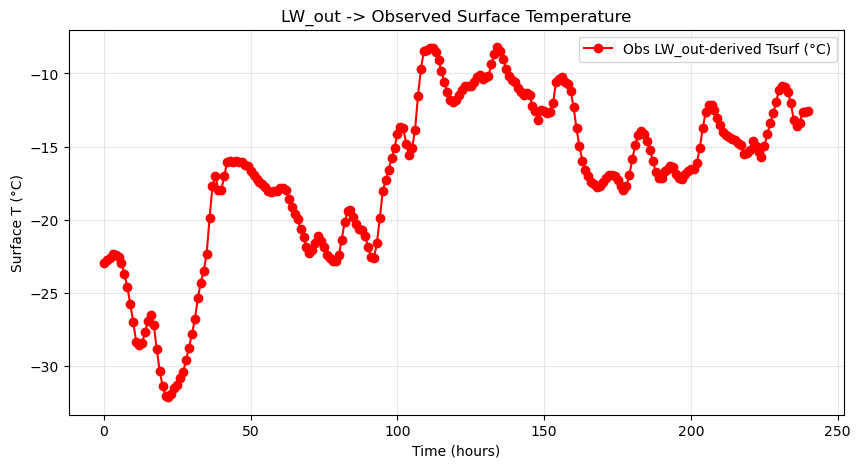

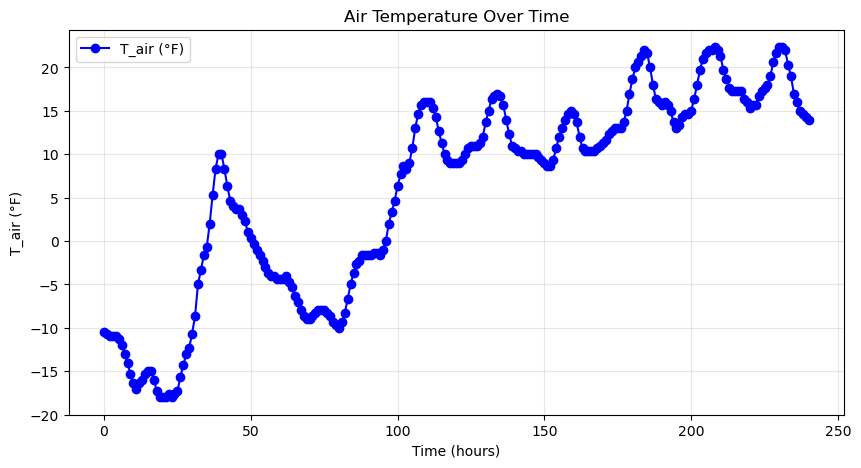

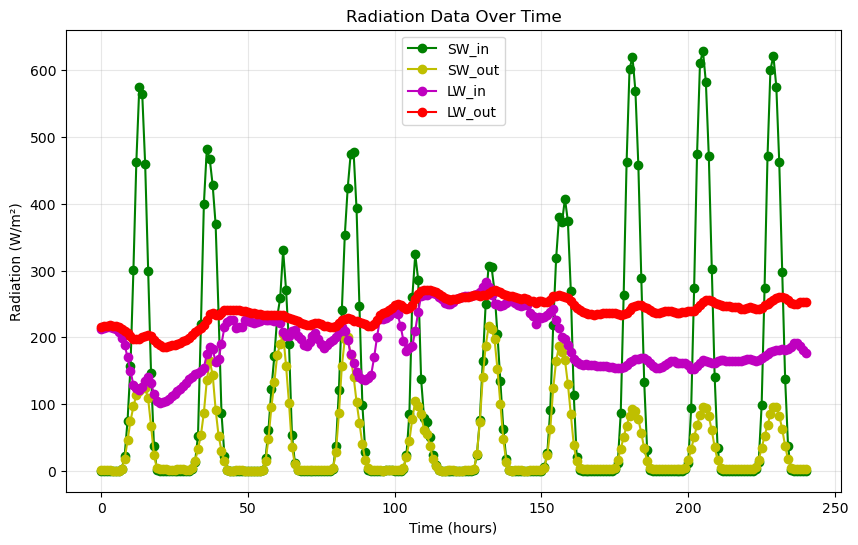

In [1151]:
# Plot observed data if True 

show_plots = True  

if show_plots:
    # Plot the observed surface temperature from LW_out
    plt.figure(figsize=(10, 5))
    plt.plot(times_arr, lw_out_surf_temp_C, 'ro-', label='Obs LW_out-derived Tsurf (°C)')
    plt.xlabel("Time (hours)")
    plt.ylabel("Surface T (°C)")
    plt.title("LW_out -> Observed Surface Temperature")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Plot the air temperature over time
    plt.figure(figsize=(10, 5))
    plt.plot(times_arr, T_air_arr, 'bo-', label='T_air (°F)')
    plt.xlabel("Time (hours)")
    plt.ylabel("T_air (°F)")
    plt.title("Air Temperature Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    # Plot the radiation data
    plt.figure(figsize=(10, 6))
    plt.plot(times_arr, sw_in_arr, 'go-', label='SW_in')
    plt.plot(times_arr, sw_out_arr, 'yo-', label='SW_out')
    plt.plot(times_arr, lw_in_arr, 'mo-', label='LW_in')
    plt.plot(times_arr, lw_out_arr, 'ro-', label='LW_out')
    plt.xlabel("Time (hours)")
    plt.ylabel("Radiation (W/m²)")
    plt.title("Radiation Data Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [1152]:
# Set up grid and the initial temperature profile

z_F = np.linspace(0.0, snow_depth_m, N+1)   # N+1 faces for N layers
z_T = 0.5*(z_F[:-1] + z_F[1:])              # Layer midpoints
dz  = z_F[1:] - z_F[:-1]                    # Thickness of each layer
H   = z_F[-1]                               # Should match snow_depth_m

print(f"Snow Depth = {H:.3f} m with {N} layers; each ~{dz[0]:.4f} m thick")


# Given variables (do not change these)
T_ground   = 273.15
T_snow_min = lw_out_surf_temp_K[0]  # observed surface temperature in K
H          = snow_depth_m           # total snow depth in m

# Define key interpolation points in a coordinate system where:
# x = 0 corresponds to the surface and x = H corresponds to the ground.
# Key points:
#   Surface (x = 0): T = T_snow_min.
#   0.2 m below the surface (x = 0.2): T = (T_snow_min + T_ground)/2.
#   0.2 m above the ground (x = H - 0.2): T = (T_snow_min + T_ground)/2.
#   Ground (x = H): T = T_ground.
x_key = np.array([0, 0.2, H - 0.2, H])
T_key = np.array([T_snow_min, (T_snow_min + T_ground) / 2.0, (T_snow_min + T_ground) / 2.0, T_ground])

# Create a PCHIP interpolator using these key points
pchip = PchipInterpolator(x_key, T_key)

# Convert the layer midpoints (z_T) into the x coordinate (distance from surface)
# Note: z_T is defined from 0 at the bottom to H at the top, so we use:
x_vals = H - z_T  # x = 0 at surface, x = H at ground

# Compute the initial temperature profile using the shape-preserving interpolator
T_init = pchip(x_vals)
top_index = np.argmax(z_T)
T_init[top_index] = T_snow_min





Snow Depth = 2.000 m with 30 layers; each ~0.0667 m thick


In [1153]:
# Functions 

def measured_air_temp(t_sec):
    # Convert measured T_air from F to C to K
    T_F = T_airF_interp(t_sec)
    T_C = (T_F - 32.0)*(5.0/9.0)
    return T_C + 273.15

def get_wind_speed(t_sec):
    # Wind speed is from data and already converted to m/s
    return wind_interp(t_sec) 

def compute_specific_humidity(T_C, RH, p=p_air):
    """
    Compute specific humidity [kg/kg] given temperature in °C,
    RH as a fraction (0-1), and atmospheric pressure p (Pa).
    """
    e_sat = 611 * np.exp((17.27 * T_C) / (T_C + 237.3))  # Saturation vapor pressure over water (Pa)
    e_act = RH * e_sat
    return (0.622 * e_act) / (p - (0.378 * e_act))

def get_air_specific_humidity(t_sec, p=p_air):
    """
    Compute the specific humidity of the air from measured temperature and RH.
    """
    T_airK = measured_air_temp(t_sec)
    T_airC = T_airK - 273.15
    RH_frac = RH_arr_interp(t_sec) / 100.0  # Convert percentage to fraction
    return compute_specific_humidity(T_airC, RH_frac, p)

def get_snow_specific_humidity(T_surfK, p=p_air):
    """
    Compute the saturation specific humidity over the snow (assumed as ice).
    """
    T_surfC = min(T_surfK - 273.15, 0.0)
    e_snow_sat = 611.0 * np.exp((22.46 * T_surfC) / (T_surfC + 272.62))  # Saturation vapor pressure over ice (Pa)
    return (0.622 * e_snow_sat) / (p - (0.378 * e_snow_sat))

def turbulent_fluxes(t_sec, T_surfK):
    """
    Compute turbulent fluxes:
      - Sensible heat flux: Q_sensible = ρ_air * c_pa * CH * U * (T_air - T_surf)
      - Latent heat flux: Q_latent = ρ_air * Lv_subl * CE * U * (q_air - q_snow)
    """
    T_airK = measured_air_temp(t_sec)
    U = get_wind_speed(t_sec)
    Q_sensible = rho_air * c_pa * CH * U * (T_airK - T_surfK)
    
    # Compute specific humidities
    q_air = get_air_specific_humidity(t_sec)
    q_snow = get_snow_specific_humidity(T_surfK)
    Q_latent = rho_air * Lv_subl * CE * U * (q_air - q_snow)
    
    return Q_sensible, Q_latent

def compute_radiative_fluxes(t_sec, T_surfK):
    """
    Compute net radiative flux at the surface:
      - Longwave: lw_net = LW_in - (ε * σ * T_surf^4)
      - Shortwave: sw_net is computed separately (distributed in the snowpack)
    """
    lw_down = LW_in_interp(t_sec)
    lw_up   = eps_snow * sigma * (T_surfK ** 4)
    lw_net  = lw_down - lw_up
    sw_net  = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def compute_idealized_radiative_fluxes(t_sec, T_surfK):
    """
    Compute the net radiative flux using an idealized LW_in based on the atmospheric temperature.
    Here we assume:
       LW_in_ideal = eps_atm * sigma * (T_airK)**4
    """
    T_airK = measured_air_temp(t_sec)
    eps_atm = 0.75  # Assumed atmospheric emissivity
    LW_in_ideal = eps_atm * sigma * (T_airK ** 4)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = LW_in_ideal - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def shortwave_absorption_twoBand(t_sec, z_faces):
    """
    Distribute the net shortwave flux into the snowpack using a two-band scheme:
    - Near-IR: strongly absorbed in upper layers
    - Visible: penetrates deeper
    Uses exponential decay (Beer–Lambert) for each band.
    """
    sw_in = SW_in_interp(t_sec)
    sw_out = SW_out_interp(t_sec)
    
    # Compute net SW entering snowpack after albedo
    sw_net = sw_in * (1 - alpha_snow)

    # Spectral band fractions (tune if needed)
    f_nir = 0.4  # fraction of SW in near-IR
    f_vis = 1.0 - f_nir

    # Attenuation coefficients (1/m) -- these are e-folding decay rates
    # Adjusted for typical fresh/dry snow: NIR ~2–5 cm, VIS ~10–20 cm
    kappa_nir = 40.0   # shallow: ~2.5 cm e-folding depth
    kappa_vis = 7.0    # deeper: ~14 cm e-folding depth

    # Incoming energy in each band at the snow surface
    sw_nir_top = sw_net * f_nir
    sw_vis_top = sw_net * f_vis

    # Depth below surface at each face (0 at surface, increasing downward)
    d_faces = H - z_faces

    # Depths of top and bottom boundaries of each layer
    d_top = d_faces[1:]     # top of each layer
    d_bottom = d_faces[:-1] # bottom of each layer

    # NIR absorption in each layer
    flux_in_nir = sw_nir_top * np.exp(-kappa_nir * d_top)
    flux_out_nir = sw_nir_top * np.exp(-kappa_nir * d_bottom)
    SW_abs_nir = flux_in_nir - flux_out_nir

    # VIS absorption in each layer
    flux_in_vis = sw_vis_top * np.exp(-kappa_vis * d_top)
    flux_out_vis = sw_vis_top * np.exp(-kappa_vis * d_bottom)
    SW_abs_vis = flux_in_vis - flux_out_vis

    # Return total absorbed shortwave flux per layer (W/m²)
    return SW_abs_nir + SW_abs_vis

def enforce_melt_freeze(T, dTdt, tau=1800):
    """
    For any layer with T > 273.15 K, subtract a latent cooling rate from dTdt.
    The latent cooling rate is (T - 273.15) / tau (in K/s), which gradually removes 
    the excess energy over a timescale tau.
    
    Parameters:
      T:     Array of layer temperatures (K)
      dTdt:  Array of temperature tendencies (K/s)
      tau:   Time scale (seconds) over which the excess energy is removed
      
    Returns:
    The original T and modified dTdt with latent cooling applied.
    """
    for i in range(len(T)):
        if T[i] > 273.15:
            # Compute latent cooling rate (K/s)
            latent_cooling_rate = (T[i] - 273.15) / tau
            # Subtract the latent cooling from the temperature tendency
            dTdt[i] -= latent_cooling_rate
            if dTdt[i] > 0:
                dTdt[i] = 0
            
    return T, dTdt

In [1154]:
def dT_dt(t_sec, T):
    """
    Compute dT/dt including conduction, radiative fluxes, turbulent fluxes,
    and distributed shortwave absorption. An optional measured-data forcing is
    applied to the surface for a limited time.
    """
    # Conductive fluxes at layer interfaces
    F = np.zeros(N+1)
    F[0] = k * (T_ground - T[0]) / dz[0]
    for i in range(1, N):
        F[i] = k * (T[i-1] - T[i]) / dz[i]
    
    # Choose radiative flux calculation method
    if use_idealized_LW:
        net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T[-1])
    else:
        net_radiative, _ = compute_radiative_fluxes(t_sec, T[-1])
    
    Q_sensible, Q_latent = turbulent_fluxes(t_sec, T[-1])
    F[N] = -(net_radiative + Q_sensible + Q_latent)
    
    # Temperature tendency from conduction/fluxes
    dTdt = np.zeros(N)
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i]) / (rho_snow * c_snow * dz[i])
    
    # Shortwave absorption distributed in the snowpack
    if use_twoBand:
        SW_profile = shortwave_absorption_twoBand(t_sec, z_F)
    else:
        SW_profile = np.zeros(N)
    for i in range(N):
        dTdt[i] += SW_profile[i] / (rho_snow * c_snow * dz[i])
    
    # Apply latent cooling adjustment instead of hard clamping
    T, dTdt = enforce_melt_freeze(T, dTdt, tau=1800)
    
    return dTdt




In [1155]:

# Solve

sol = solve_ivp(fun=dT_dt,
                t_span=(0, t_end),
                y0=T_init,
                method='RK45',
                max_step=dt_max,
                rtol=1e-5,
                atol=1e-7,
                dense_output=False)
time = sol.t
T_layers = sol.y
print(f"Integration done with {len(time)} time steps over {t_end/3600} hours.")


Integration done with 2404 time steps over 240.0 hours.


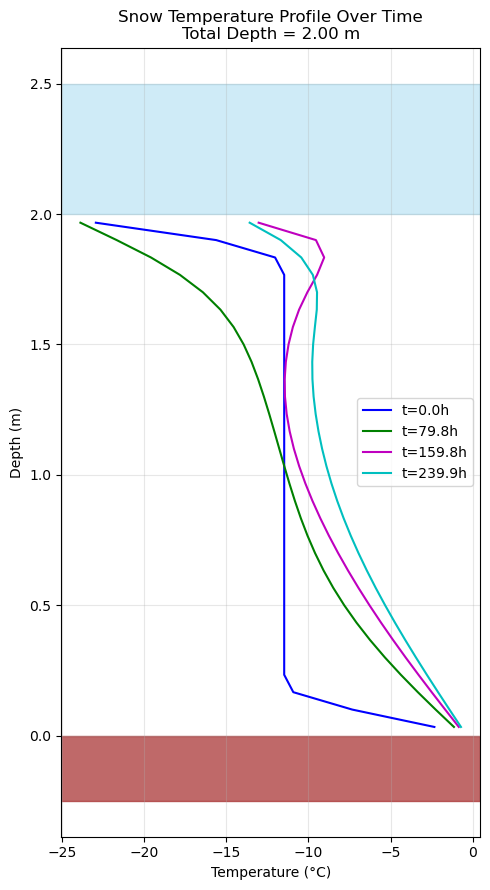

In [1156]:
final_temp = T_layers[:,-1]
plt.figure(figsize=(5,9))

n_snaps = 4
snap_ids = np.linspace(1, len(time)-2, n_snaps, dtype=int)
colors   = ['b','g','m','c']
for i, idx in enumerate(snap_ids):
    T_s  = T_layers[:, idx] - 273.15
    t_hrs= time[idx]/3600
    plt.plot(T_s, z_T, color=colors[i], label=f"t={t_hrs:.1f}h")

plt.axhspan(-0.25, 0, color='brown', alpha=0.7)
plt.axhspan(H, H+0.5, color='skyblue', alpha=0.4)
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title(f"Snow Temperature Profile Over Time\nTotal Depth = {H:.2f} m")
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

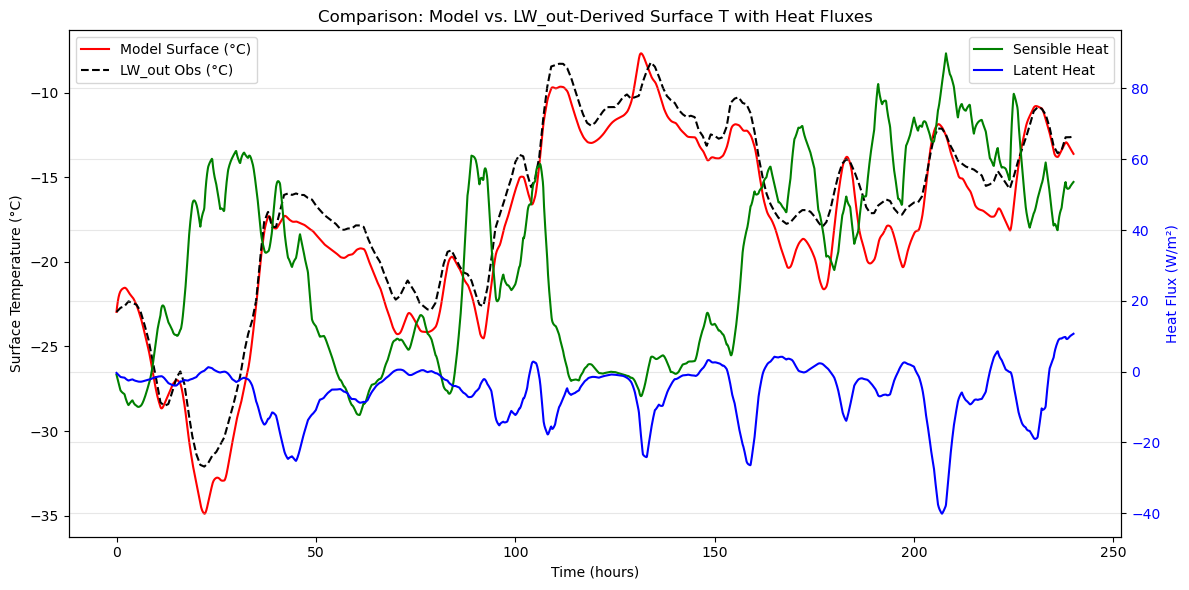

In [1157]:

# ------------------------------------------------------------------------------
# Compare Observed vs. Model at Surface
# ------------------------------------------------------------------------------
model_time_sec   = sol.t
model_surf_tempC = T_layers[-1,:] - 273.15
obs_surf_tempC   = surf_temp_obs_interp(model_time_sec)

# Calculate sensible and latent heat fluxes for plotting
Q_sensible_arr = []
Q_latent_arr = []
total_flux_arr = []
time_hours = model_time_sec/3600

for i, t in enumerate(model_time_sec):
    T_surf = T_layers[-1, i]  # Surface temperature at time t
    Q_sensible, Q_latent = turbulent_fluxes(t, T_surf)
    Q_sensible_arr.append(Q_sensible)
    Q_latent_arr.append(Q_latent)

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot surface temperatures on the first y-axis
ax1.plot(time_hours, model_surf_tempC, 'r-', label='Model Surface (°C)')
ax1.plot(time_hours, obs_surf_tempC, 'k--', label='LW_out Obs (°C)')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Surface Temperature (°C)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create second y-axis for heat fluxes
ax2 = ax1.twinx()
ax2.plot(time_hours, Q_sensible_arr, 'g-', label='Sensible Heat')
ax2.plot(time_hours, Q_latent_arr, 'b-', label='Latent Heat')
ax2.set_ylabel("Heat Flux (W/m²)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

plt.title("Comparison: Model vs. LW_out-Derived Surface T with Heat Fluxes")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



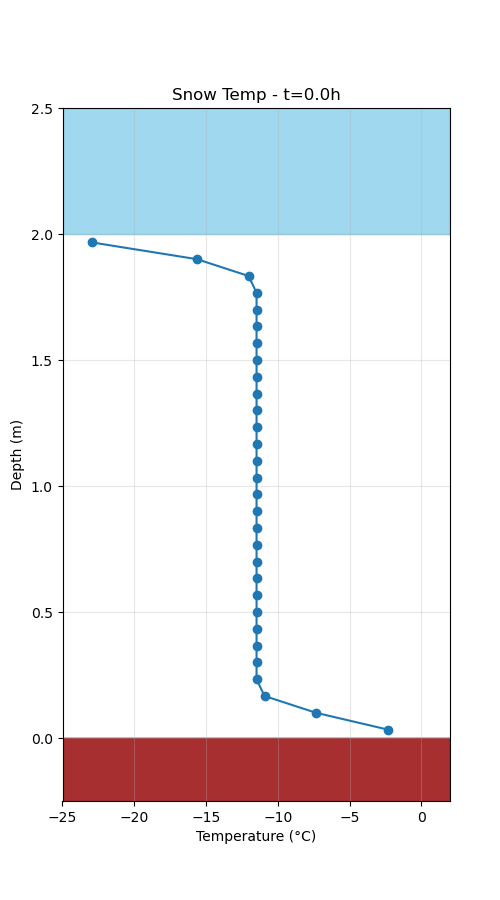

In [1158]:
# Create a gif animation 
generate_animation = True  # Set to False to skip animation generation

if generate_animation:
    fig, ax = plt.subplots(figsize=(5,9))
    line, = ax.plot([],[],'-o')

    def init_anim():
        ax.set_xlim(-25, 2)
        ax.set_ylim(-0.25, H+0.5)
        ax.set_xlabel("Temperature (°C)")
        ax.set_ylabel("Depth (m)")
        ax.set_title("Snow Temperature Profile Evolution")
        ax.grid(True, alpha=0.3)
        ax.axhspan(-0.25,0, color='brown', alpha=0.7)
        ax.axhspan(H,H+0.5, color='skyblue', alpha=0.4)
        return line,

    def animate(i):
        idx = int(i*len(time)/100)
        if idx>=len(time):
            idx=len(time)-1
        T_s = T_layers[:, idx]-273.15
        hrs= time[idx]/3600
        ax.set_title(f"Snow Temp - t={hrs:.1f}h")
        line.set_data(T_s, z_T)
        return line,

    ani = FuncAnimation(fig, animate, frames=101,
                        init_func=init_anim, interval=100, blit=True)
    ani.save('temperature_profile_evolution.gif', writer='pillow', fps=5)
    plt.close()
    display(Image('temperature_profile_evolution.gif'))
else:
    print("Animation generation skipped.")
